In [60]:
import pandas as pd
from numpy import array
from numpy import asarray
import matplotlib.pyplot as plt
from datetime import datetime
import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dropout
from tensorflow.keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense


In [61]:
train = pd.read_csv('train.csv',encoding='utf8')
test = pd.read_csv('test.csv',encoding='utf8')

In [62]:
print(type(train["tweet"].values))
docs = list(train["tweet"].values)
print(type(docs))
print(len(docs))

<class 'numpy.ndarray'>
<class 'list'>
31962


In [4]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [5]:
test.isna().count()


id       17197
tweet    17197
dtype: int64

In [6]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [67]:
print(train["label"].value_counts())
print(2242/29720)

0    29720
1     2242
Name: label, dtype: int64
0.07543741588156123


In [40]:
y = train["label"]
print(len(y))
maxlength = int(100/2)

t = Tokenizer()
t.fit_on_texts(train['tweet'].values)
X = t.texts_to_sequences(train['tweet'].values)
X = pad_sequences(X,maxlen=maxlength,padding='post')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=52)

print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_valid shape: ",X_valid.shape)
print("y_valid shape: ",y_valid.shape)

31962
X_train shape:  (25569, 50)
y_train shape:  (25569,)
X_valid shape:  (6393, 50)
y_valid shape:  (6393,)


In [41]:
print(X_train.shape[1],)
vocab_size = len(t.word_index) + 1
print(vocab_size)

50
45890


In [52]:
start = datetime.now()
model = Sequential()
model.add(Embedding(vocab_size,32,input_length=maxlength))
model.add(LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1,recurrent_activation="sigmoid",activation = "tanh"))
#model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1,activation='sigmoid'))

print(model.summary())

"""train model section"""
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics = ['acc'])
print(model.summary)
history = model.fit(X_valid,y_valid,epochs=10,batch_size = 20, validation_split = 0.2)
end=datetime.now()
print("run time:",end-start)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 32)            1468480   
                                                                 
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,493,377
Trainable params: 1,493,377
Non-trainable params: 0
_________________________________________________________________
None
<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x00000181CC96D760>>
Epoch 1/10
256/256 [==============================] - 51s 192ms/step - lo

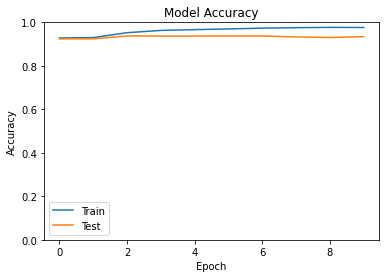

In [53]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Test"])
plt.ylim([0,1])
plt.show()

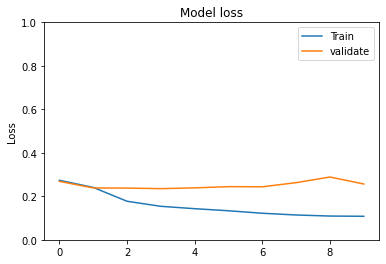

In [54]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.ylabel("Loss")
plt.title("Model loss")
plt.ylim([0,1])
plt.legend(["Train","validate"])
plt.show()

In [55]:
"""predictions"""
t = Tokenizer()
t.fit_on_texts(test['tweet'].values)
encoded_test_tweets = t.texts_to_sequences(train['tweet'].values)
padded_test_tweets = pad_sequences(encoded_test_tweets,maxlen=maxlength,padding='post')

In [56]:
prob = model.predict(padded_test_tweets,verbose=1,batch_size=20)

1599/1599 [==============================] - 110s 69ms/step


In [59]:
pred = []
for i in range(len(prob)):
    if prob[i] > 0.5:
        pred.append(1)
    else:
        pred.append(0)

#sample prediction
for i in range(10):
    index = random.randint(0,len(prob))
    print(encoded_test_tweets[index],pred[index])

[22229, 5571, 4172, 124, 988, 61, 82, 1779, 4, 7387, 1497, 5893, 3, 2] 0
[2, 295, 291, 302, 22] 0
[577, 6789, 598, 416, 751] 0
[476, 12, 2857, 272, 22, 1307, 975, 394] 0
[152, 9, 90] 0
[1, 196, 278, 7, 3, 70, 6812, 1139, 9, 3] 0
[1267, 64, 13, 9, 2, 240, 1061] 0
[11, 109, 109, 63, 1285, 2298, 630, 4513, 1133, 15969] 0
[1, 79, 303, 120, 1473, 7, 794, 1, 205, 377, 22581] 0
[1, 2415, 2, 4592, 3867, 1888, 2415, 2, 201, 4593, 3868, 1169, 42, 6416] 0


In [58]:
hatespeech = round((sum(pred)/len(pred)),3)*100
print("the percentage of hate speech tweets is: {}%".format(hatespeech))

the percentage of hate speech tweets is: 2.3%
